In [2]:
from google.colab import drive
drive.mount('/content/drive') #connect drive if you are using google colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import required libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2

# Dataset Preparation

In [4]:
batch_size = 32    #set batch size
img_height = 244   # set image height
img_width = 244    # set image width

In [5]:
data_dir = '/content/drive/MyDrive/DataSet Playing Cards' #define path of dataset folder

In [6]:
#convert image dataset from specified directory into format supported by tensorflow i.e tf.data.Dataset format
#By default labels will be inferred from folder name of subdirectories
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,                #directory where images are located
  validation_split=0.2,    #fraction of data used for validation                              
  subset="training",       #This subset of data is used for training
  seed=123,                # reproduce same data for training and testing
  image_size=(img_height, img_width), #Resize image to specified size
  batch_size=batch_size)  #data is produced in batches

Found 521 files belonging to 10 classes.
Using 417 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation", #this subset is used for validation
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 521 files belonging to 10 classes.
Using 104 files for validation.


In [8]:
class_names = train_ds.class_names  #this will return class names present in the data
print(class_names)

['Ace', 'Eight', 'Five', 'Four', 'Nine', 'Seven', 'Six', 'Ten', 'Three', 'Two']


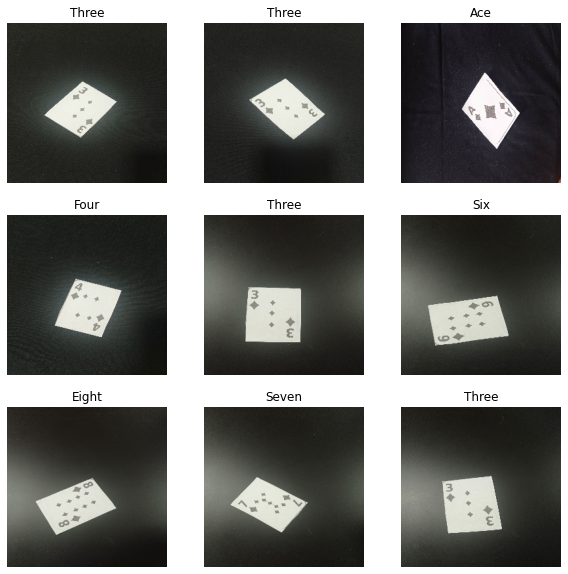

In [9]:
#Taking a look at some of the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)    #shape of image batch
  print(labels_batch.shape)   #shape of labels batch
  break

(32, 244, 244, 3)
(32,)


In [11]:
#This step is used for faster processing
#Data is shufflled. Some batches are prefetched in memory. Data is also catched so that it can be faster processed.
AUTOTUNE = tf.data.AUTOTUNE 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
#this step will normalize pixels of an image. Pixels having range from 0 to 255 are converted into 0 and 1 to avoid effect of scaling.
normalization_layer = layers.Rescaling(1./255) #Define amount of scaling i.e 1/255
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) #apply scaling on each image in train dataset
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.052289143 0.9941503


# Model 1

In [13]:
num_classes = len(class_names)
#Keras' Sequential API is used for model building.
#sequential API allows to add layers of neural network one after one
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), #This layer is used to normalize the data
  layers.Conv2D(16, 3, padding='same', activation='relu'), #This is convolution layer with 16 filters of 3x3 size. Convolution extracts features from images.
  layers.MaxPooling2D(),  #This layer is used to provide translation invarience to the model
  layers.Conv2D(32, 3, padding='same', activation='relu'), #Activation function of relu is used for non linear transformation( to learn complex features)
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'), #This is fully connected layer with 128 number of neurons
  # output layer is fully connected layer with number of neurons equal to number of classes. Softmax activations give probabilistic outputs.
  layers.Dense(num_classes, activation='softmax') 
])

In [14]:
#model.compile method is used for defining optimizer, loss function and performance metric
#adam optimizer is most popular and gives better results on almost all the datasets
#sparse categorical crossentropy loss is used for multiclass classification problems
#accuracy is used as a metric in classification problems
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 244, 244, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        1

In [16]:
#epochs are defined as number of times model is run on complete dataset
#model.fit() method is used for training model
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


14/14 [==============================] - 26s 1s/step - loss: 2.8617 - accuracy: 0.1319 - val_loss: 2.2999 - val_accuracy: 0.1154
Epoch 2/100
14/14 [==============================] - 1s 71ms/step - loss: 2.2802 - accuracy: 0.1775 - val_loss: 2.2627 - val_accuracy: 0.2115
Epoch 3/100
14/14 [==============================] - 1s 67ms/step - loss: 2.1497 - accuracy: 0.2230 - val_loss: 2.0992 - val_accuracy: 0.1923
Epoch 4/100
14/14 [==============================] - 1s 68ms/step - loss: 1.7707 - accuracy: 0.3837 - val_loss: 1.8356 - val_accuracy: 0.3365
Epoch 5/100
14/14 [==============================] - 1s 67ms/step - loss: 1.2966 - accuracy: 0.5659 - val_loss: 1.5048 - val_accuracy: 0.4904
Epoch 6/100
14/14 [==============================] - 1s 66ms/step - loss: 0.8794 - accuracy: 0.7002 - val_loss: 1.6481 - val_accuracy: 0.5000
Epoch 7/100
14/14 [==============================] - 1s 67ms/step - loss: 0.5970 - accuracy: 0.8034 - val_loss: 1.7437 - val_accuracy: 0.5481
Epoch 8/100
14/14 [

In [17]:
#save model
model.save('model_1.h5')

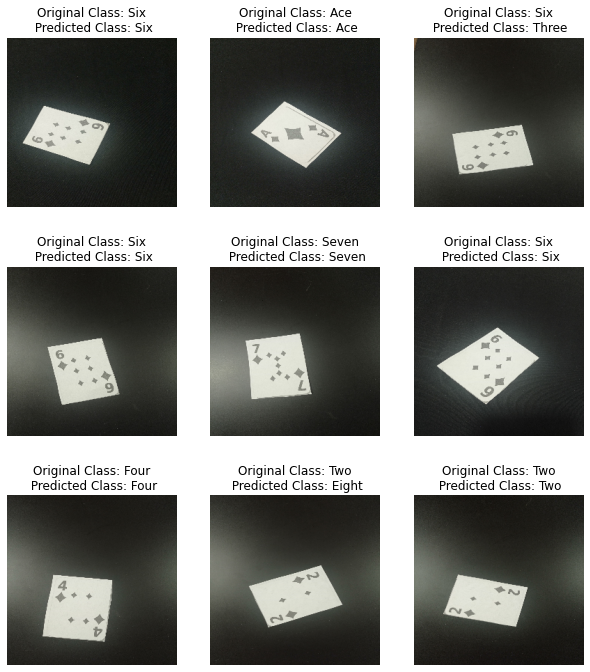

In [18]:
#Plot predicted labels with original labels
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1, right=0.9, top=1, bottom=0.1)
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predictions = model.predict(images[i].numpy().reshape(1, img_height, img_width, 3))
    score = predictions[0]
    predicted_class = class_names[np.argmax(score)]
    plt.title(f"Original Class: {class_names[labels[i]]}\n Predicted Class: {predicted_class}")
    plt.axis("off")

# Model 2

In [31]:
#Add some data augmentation of data by flipping, rotation and zooming of images
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [32]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


14/14 [==============================] - 5s 247ms/step - loss: 2.3083 - accuracy: 0.1295 - val_loss: 2.2925 - val_accuracy: 0.1058
Epoch 2/50
14/14 [==============================] - 3s 228ms/step - loss: 2.2885 - accuracy: 0.1391 - val_loss: 2.2950 - val_accuracy: 0.1058
Epoch 3/50
14/14 [==============================] - 3s 227ms/step - loss: 2.2878 - accuracy: 0.1391 - val_loss: 2.2970 - val_accuracy: 0.1058
Epoch 4/50
14/14 [==============================] - 3s 228ms/step - loss: 2.2823 - accuracy: 0.1391 - val_loss: 2.2878 - val_accuracy: 0.1058
Epoch 5/50
14/14 [==============================] - 3s 228ms/step - loss: 2.2889 - accuracy: 0.1655 - val_loss: 2.2817 - val_accuracy: 0.1442
Epoch 6/50
14/14 [==============================] - 3s 228ms/step - loss: 2.2603 - accuracy: 0.1871 - val_loss: 2.1716 - val_accuracy: 0.1635
Epoch 7/50
14/14 [==============================] - 3s 229ms/step - loss: 2.2424 - accuracy: 0.1775 - val_loss: 2.2495 - val_accuracy: 0.1538
Epoch 8/50
14/14 

In [35]:
model.save('model_2.h5')

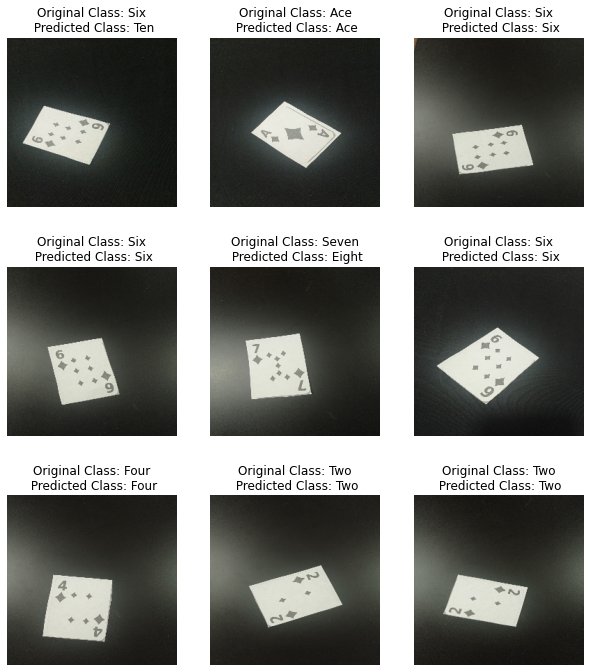

In [36]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1, right=0.9, top=1, bottom=0.1)
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predictions = model.predict(images[i].numpy().reshape(1, img_height, img_width, 3))
    score = predictions[0]
    predicted_class = class_names[np.argmax(score)]
    plt.title(f"Original Class: {class_names[labels[i]]}\n Predicted Class: {predicted_class}")
    plt.axis("off")

# Model 3

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16

In [26]:
#We will use VGG16 model for transfer learning which is trained on large imagenet dataset
#We will use imagenet weights and train only top layers of neural network
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False ## Not trainable weights
model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1605696   
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 10)                330       
                                                                 
Total params: 16,322,794
Trainable params: 1,608,106
Non-trainable params: 14,714,688
___________________________________

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


14/14 [==============================] - 21s 656ms/step - loss: 5.3247 - accuracy: 0.2398 - val_loss: 2.5225 - val_accuracy: 0.4231
Epoch 2/10
14/14 [==============================] - 5s 349ms/step - loss: 2.4703 - accuracy: 0.4412 - val_loss: 2.0506 - val_accuracy: 0.4712
Epoch 3/10
14/14 [==============================] - 5s 348ms/step - loss: 1.0495 - accuracy: 0.6739 - val_loss: 1.3878 - val_accuracy: 0.6154
Epoch 4/10
14/14 [==============================] - 5s 348ms/step - loss: 0.4887 - accuracy: 0.8441 - val_loss: 0.9921 - val_accuracy: 0.7212
Epoch 5/10
14/14 [==============================] - 5s 348ms/step - loss: 0.2577 - accuracy: 0.9281 - val_loss: 0.9662 - val_accuracy: 0.7692
Epoch 6/10
14/14 [==============================] - 5s 347ms/step - loss: 0.1660 - accuracy: 0.9544 - val_loss: 0.8075 - val_accuracy: 0.8077
Epoch 7/10
14/14 [==============================] - 5s 348ms/step - loss: 0.0988 - accuracy: 0.9712 - val_loss: 0.7776 - val_accuracy: 0.8462
Epoch 8/10
14/14

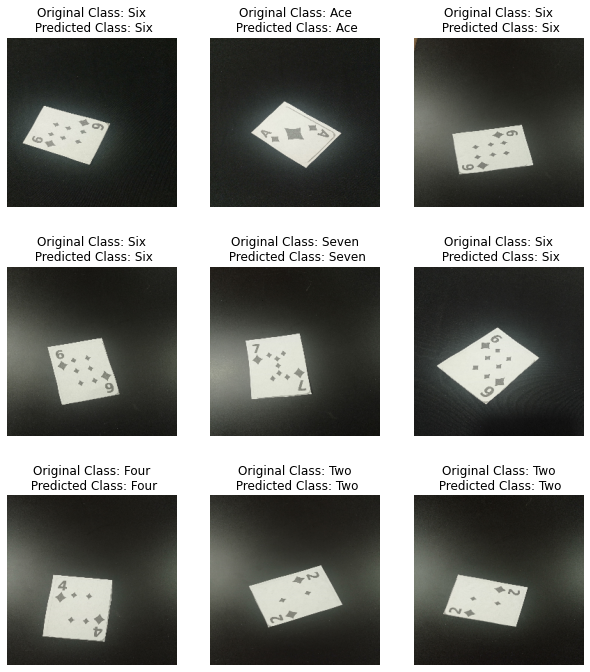

In [29]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1, right=0.9, top=1, bottom=0.1)
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predictions = model.predict(images[i].numpy().reshape(1, img_height, img_width, 3))
    score = predictions[0]
    predicted_class = class_names[np.argmax(score)]
    plt.title(f"Original Class: {class_names[labels[i]]}\n Predicted Class: {predicted_class}")
    plt.axis("off")

In [30]:
model.save('model_3.h5')

### Important Points
1. Model 1 is overfitting on the data. We can observe that from train and val accuracy.
2. We have used augmentation for Model 2 which avoids the situation of overfitting.
3. We have used transfer learning approach in Model 3, which improves performance significantly with slight overfitting. 